# 1次元の混合正規分布に対してのEMアルゴリズムを実装・描画
- https://cartman0.hatenablog.com/entry/2019/07/01/EM%E3%82%A2%E3%83%AB%E3%82%B4%E3%83%AA%E3%82%BA%E3%83%A0%E3%81%A7%E6%B7%B7%E5%90%88%E6%AD%A3%E8%A6%8F%E5%88%86%E5%B8%83%28MoG%29%E3%81%AE%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF%E3%82%92%E5%B0%8E
-  https://qiita.com/ta-ka/items/3e8b127620ac92a32864

In [1]:
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline
warnings.simplefilter('ignore')

In [2]:
# E-step
def EStep(k_size, data_x, lambda_vec, mu_vec, sigma2_vec):
    '''
    data_x[i]
    lambda[k]
    mu[k]
    sigma[k]
    '''
    I = len(data_x)
    # 中身を初期化せずに配列を作成する関数である。
    # 2行, 1000列の配列を生成
    responsibility = sp.empty((k_size, I))
    
    for k in sp.arange(k_size):
        norm = stats.norm(loc=mu_vec[k], scale=sp.sqrt(sigma2_vec[k]))
        #responsibility[k] =  norm.pdf(data_x)
        responsibility[k] = lambda_vec[k] * norm.pdf(data_x)

    responsibility = responsibility / sp.sum(responsibility, axis=0)
    return responsibility

def MStep(k_size, responsibility, data_x):

    lambda_vec = sp.empty(k_size)
    mu_vec = sp.empty(k_size)
    sigma2_vec = sp.empty(k_size)

    for k in sp.arange(k_size):
        r_k = responsibility[k]
        #lambda_vec[k] = sp.sum(r_k) / sp.sum(responsibility)
        lambda_vec[k] = sp.sum(r_k) / responsibility.shape[1]
        #mu_vec[k] = sp.sum(r_k * data_x) / sp.sum(r_k)
        mu_vec[k] = sp.sum(r_k * data_x) / sp.sum(r_k)
        sigma2_vec[k] = sp.sum(r_k * (data_x - mu_vec[k])**2) / sp.sum(r_k)

    return lambda_vec, mu_vec, sigma2_vec

In [3]:
def calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec):
    pdf = sp.zeros_like(x)

    for k in sp.arange(k_size):
        norm_k = stats.norm(loc=mu_vec[k], scale=sp.sqrt(sigma2_vec[k]))
        
        # pdf (Probability density function) 確率密度関数
        # xのときの値を取得
        pdf += lambda_vec[k] * norm_k.pdf(x)
    return pdf

# データの生成  
- f1：平均40, 分散100, データ数60   
- f2：平均70, 分散25, データ数40  
- f1とf2の割合は6:4

In [28]:
# 乱数seedの固定
np.random.seed(seed=123)

# 平均40, 分散100
N1 = stats.norm(loc=40, scale=sp.sqrt(10*10))
# 平均70, 分散25
N2 = stats.norm(loc=70, scale=sp.sqrt(5*5))

# rvs (Random variates) 確率変数
s1 = N1.rvs(size=100)
s2 = N2.rvs(size=50)

# データの連結
data_x = sp.hstack((s1, s2))
data_x

array([29.14369397, 49.97345447, 42.82978498, 24.93705286, 34.21399748,
       56.51436537, 15.73320757, 35.71087371, 52.65936259, 31.33259598,
       33.21113848, 39.05291031, 54.91389626, 33.61098003, 35.5601804 ,
       35.65648724, 62.05930083, 61.86786089, 50.04053898, 43.86186399,
       47.37368576, 54.90732028, 30.64166132, 51.75829045, 27.46119332,
       33.62248498, 49.07105196, 25.713193  , 38.5993128 , 31.38245104,
       37.44380629, 12.01410895, 22.28466895, 33.00122765, 49.27462432,
       38.26364317, 40.02845916, 46.88222711, 31.20463657, 42.83627324,
       31.94633482, 22.72330506, 36.09100206, 45.73805862, 43.38589051,
       39.88169506, 63.92365266, 44.1291216 , 49.78736006, 62.38143338,
       27.05914677, 29.6121179 , 57.43712225, 32.01937265, 40.2968323 ,
       50.69315969, 48.90706391, 57.54886182, 54.95644137, 50.6939267 ,
       32.27291286, 47.94862668, 43.14271995, 26.7373454 , 54.17299046,
       48.07236535, 40.45490081, 37.66907939, 28.01698855, 41.99

(array([0.0028178 , 0.00469633, 0.02348165, 0.01878532, 0.01408899,
        0.01878532, 0.01033193, 0.01784605, 0.02254238, 0.00751413]),
 array([12.01410895, 19.11185001, 26.20959108, 33.30733215, 40.40507322,
        47.50281429, 54.60055536, 61.69829643, 68.7960375 , 75.89377857,
        82.99151964]),
 <a list of 10 Patch objects>)

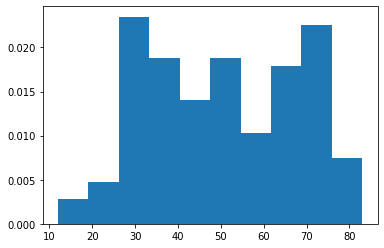

In [29]:
plt.hist(data_x,  density=True)

## 初期値の設定  
- データをランダムに2分割  
- それぞれの平均値を初期値に用いる
- 分散は全体の標本分散を用いる  
  
## 参考
- 入門　パターン認識と機械学習(https://www.coronasha.co.jp/np/isbn/9784339024791/)


In [30]:
# データをランダムに2分割
random_x = np.split(data_x, 2)
random_x1 = random_x[0]
random_x2 = random_x[1]

In [31]:
np.var(random_x2)


263.02515399964096

In [32]:
mu1_first = np.mean(random_x1)
sigma1_first = np.sum((random_x1 - np.mean(data_x))**2)/random_x1.shape[0]
#sigma1_first = np.var(random_x1)
print("mu1の初期値", mu1_first)
print("sigma1の初期値", sigma1_first)

mu2_first = np.mean(random_x2)
sigma2_first = np.sum((random_x2 - np.mean(data_x))**2)/random_x2.shape[0]
#sigma2_first = np.var(random_x2)
print("mu2の初期値", mu2_first)
print("sigma2の初期値", sigma2_first)

mu1の初期値 40.428463786119316
sigma1の初期値 233.30219339149292
mu2の初期値 60.3302033124217
sigma2の初期値 362.0449630428373


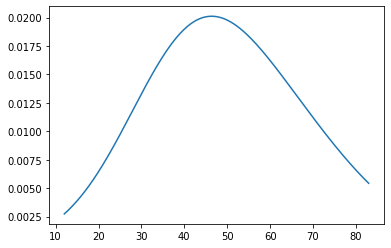

In [33]:
# 混合正規分布の数
k_size = 2

# 正規分布の割合
lambda_vec=[0.5, 0.5]

# 平均(mu)の初期値
mu_vec=[mu1_first, mu2_first]
# 分散(sigma)の初期値
sigma2_vec=[sigma1_first, sigma2_first]

# データ(-6から6までを200こ)
x = sp.linspace(np.min(random_x), np.max(random_x), 10000)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec), label="ini")


i: 0 lambda [0.4945 0.5055] mu [41.617  58.9509] sigma2 [202.1862 242.5028]
i: 10 lambda [0.5252 0.4748] mu [36.4859 65.7473] sigma2 [85.932  82.2015]
i: 20 lambda [0.6165 0.3835] mu [38.8506 68.9131] sigma2 [109.8699  42.4161]
i: 30 lambda [0.6644 0.3356] mu [40.3054 70.3252] sigma2 [131.5273  27.8646]
i: 40 lambda [0.6727 0.3273] mu [40.5842 70.5134] sigma2 [136.4896  26.3965]
i: 50 lambda [0.674 0.326] mu [40.6287 70.5418] sigma2 [137.2972  26.182 ]
i: 60 lambda [0.6742 0.3258] mu [40.6359 70.5463] sigma2 [137.4273  26.148 ]
i: 70 lambda [0.6743 0.3257] mu [40.637 70.547] sigma2 [137.4482  26.1425]
i: 80 lambda [0.6743 0.3257] mu [40.6372 70.5472] sigma2 [137.4516  26.1417]


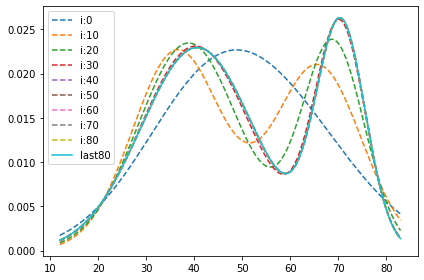

In [34]:
# 80回繰り返す
for i in sp.arange(80+1):
    # Estep
    # responsibilityの更新 
    responsibility = EStep(k_size, data_x, lambda_vec, mu_vec, sigma2_vec)
    
    # Mstep
    # 混合割合, 平均, 分散の更新
    lambda_vec, mu_vec, sigma2_vec = MStep(k_size, responsibility, data_x)
    
    if i % 10 == 0:
        print("i:", i, "lambda", lambda_vec.round(4), "mu", mu_vec.round(4), "sigma2", sigma2_vec.round(4))
        plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec), label=f"i:{i}", linestyle="--")
        
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec), label=f"last{i}", linestyle="-")

plt.legend()
plt.tight_layout()
plt.show()

In [35]:
k_size

2

In [36]:
print("f1の混合比率", lambda_vec[0])
print("mu1", mu_vec[0])
print("sigma1", sigma2_vec[0])

f1の混合比率 0.6742849849989367
mu1 40.6372160358075
sigma1 137.45155498085717


In [37]:
print("f2の混合比率", lambda_vec[1])
print("mu2", mu_vec[1])
print("sigma2", sigma2_vec[1])

f2の混合比率 0.32571501500106326
mu2 70.54715897605298
sigma2 26.14166629704663


# 真の値
- 平均40, 分散100  
N1 = stats.norm(loc=40, scale=sp.sqrt(10*10))  
- 平均70, 分散25  
N2 = stats.norm(loc=70, scale=sp.sqrt(5*5))  

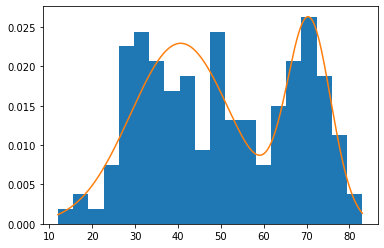

In [38]:
# 推定された分布の可視化
plt.hist(data_x, bins=20, density=True)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, mu_vec, sigma2_vec), label=f"last{i}", linestyle="-")

(array([0.0028178 , 0.0028178 , 0.0028178 , 0.        , 0.0056356 ,
        0.00845339, 0.01972459, 0.01690679, 0.03381358, 0.01408899,
        0.02254238, 0.01972459, 0.01127119, 0.02254238, 0.00845339,
        0.01972459, 0.02817798, 0.00845339, 0.01408899, 0.0056356 ,
        0.01127119, 0.01690679, 0.01408899, 0.02254238, 0.02254238,
        0.03099578, 0.01408899, 0.01408899, 0.0056356 , 0.0028178 ]),
 array([12.01410895, 14.38002264, 16.74593632, 19.11185001, 21.4777637 ,
        23.84367739, 26.20959108, 28.57550477, 30.94141846, 33.30733215,
        35.67324584, 38.03915953, 40.40507322, 42.77098691, 45.1369006 ,
        47.50281429, 49.86872798, 52.23464167, 54.60055536, 56.96646905,
        59.33238274, 61.69829643, 64.06421012, 66.43012381, 68.7960375 ,
        71.16195119, 73.52786488, 75.89377857, 78.25969226, 80.62560595,
        82.99151964]),
 <a list of 30 Patch objects>)

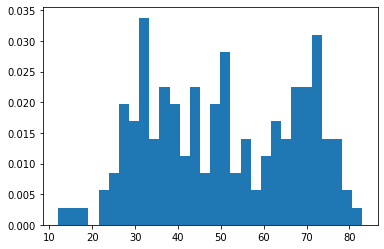

In [39]:
# 平均40, 分散100
new_N1 = stats.norm(loc=mu_vec[0], scale=sp.sqrt(sigma2_vec[0]))
# 平均70, 分散25
new_N2 = stats.norm(loc=mu_vec[1], scale=sp.sqrt(sigma2_vec[1]))

# rvs (Random variates) 確率変数
new_s1 = new_N1.rvs(size=int(lambda_vec[0]*100))
new_s2 = new_N2.rvs(size=int(lambda_vec[1]*100))


plt.hist(data_x, bins=30, density=True)

(array([ 1.,  1.,  1.,  3., 12., 19., 16.,  7.,  6.,  1.]),
 array([ 2.7564127 ,  9.12459034, 15.49276799, 21.86094564, 28.22912328,
        34.59730093, 40.96547858, 47.33365622, 53.70183387, 60.07001152,
        66.43818916]),
 <a list of 10 Patch objects>)

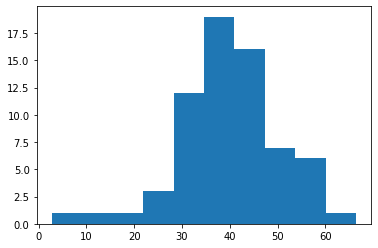

In [48]:
plt.hist(new_s1)

(array([1., 1., 5., 1., 2., 6., 4., 6., 3., 3.]),
 array([59.54169211, 61.17013454, 62.79857697, 64.4270194 , 66.05546183,
        67.68390427, 69.3123467 , 70.94078913, 72.56923156, 74.19767399,
        75.82611643]),
 <a list of 10 Patch objects>)

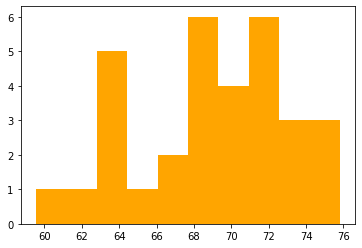

In [47]:
plt.hist(new_s2, color="orange")